In [1]:
#export
"""
This is for advanced machine learning models or complex data structures and algorithms, presented in a digestible interface
"""
from typing import Callable, Union, List, overload, Iterator, Any, Set, Tuple
from k1lib.cli.init import BaseCli, fastF
import k1lib.cli as cli; import k1lib, os, math
from k1lib.cli.typehint import *
import numpy as np; from collections import deque
try: import torch; hasTorch = True
except: hasTorch = False

In [2]:
cli.init.patchNumpy()

In [3]:
#export
__all__ = ["embed", "complete", "kmeans", "tsne", "bloom"]
settings = k1lib.Settings().add("cuda", None, "whether to run the models on the GPU or not. True for GPU, False for CPU. None (default) for GPU if available, else CPU")
k1lib.settings.cli.add("models", settings, "settings related to k1lib.cli.models");

In [4]:
#export
_cuda = k1lib.Wrapper(None)
def cuda() -> bool: # internal func to figure out whether the funcs should run on gpus or not
    if _cuda() is None: _cuda.value = torch.cuda.is_available() and torch.cuda.device_count() >= 1
    return _cuda()
sentence_transformers = k1lib.dep("sentence_transformers"); embed_models_cpu = dict(); embed_models_cuda = dict()
def embed_models(): return embed_models_cuda if cuda() else embed_models_cpu
settings.add("embed", k1lib.Settings().add("model", "all-MiniLM-L6-v2", "what model to choose from `SentenceTransformer` library").add("bs", 512, "batch size to feed the model. For all-MiniLM-L6-v2, it seems to be able to deal with anything. I've tried 10k batch and it's still doing good"))
def embed_model(): # returns correct function capable of passing in List[str] and will spit out np.ndarray with shape (N, F)
    modelName = settings.embed.model
    if modelName not in embed_models():
        model = sentence_transformers.SentenceTransformer(modelName)
        if cuda(): model = model.cuda()
        embed_models()[modelName] = model.encode
    return embed_models()[modelName]
class embed(BaseCli):
    def __init__(self, norm=True):
        """Gets an embedding vector for every sentence piped into this.
Example::

    # returns (384,)
    "abc" | embed() | shape()
    # returns (2, 384). Don't worry that this is less performant, as behind the scenes, it will automatically batch all lines together and pass through the model only once
    ["abc", "def"] | embed().all() | shape()

There are several settings you can set::

    settings.cli.models.embed.model = "msmarco-distilbert-base-v4" # specifies model used in this function
    settings.cli.models.cuda = False # tells the system to only use the CPU to run the models

I'd suggest picking "all-MiniLM-L6-v2" for general purpose tasks, and "msmarco-distilbert-base-v4"
for document-lookup style applications.

:param norm: whether to normalize the output embeddings or not"""
        self.model = embed_model(); self.normF = (lambda x: (x - (x | cli.toMean())) / (x | cli.toStd())) if norm else (lambda x: x)
    def __ror__(self, it): return self.normF(self.model([it])[0] if isinstance(it, str) else self.model(list(it)))
    def _all_opt(self, it:List[str]): return it | cli.batched(settings.embed.bs, True) | cli.apply(self.__ror__) | cli.joinStreams()

In [5]:
assert ["abc", "def"] | embed().all() | cli.shape() == (2, 384)
assert "abc" | embed() | cli.shape() == (384,)

In [6]:
#export
transformers = k1lib.dep("transformers"); generic_models_cpu = dict(); generic_models_cuda = dict()
def generic_models(): return generic_models_cuda if cuda() else generic_models_cpu
settings.add("generic", k1lib.Settings().add("model", "google/flan-t5-xl", "what model to choose from `transformers` library").add("bs", 16, "batch size to feed the model. For flan-t5-xl, 16 seems to be the sweet spot for 24GB VRAM (RTX 3090/4090). Decrease it if you don't have as much VRAM"))
def generic_model(maxTokens=100): # returns correct function capable of passing in str|List[str] and will spit out List[str]
    modelName = settings.generic.model
    if modelName not in generic_models():
        if modelName.startswith("google/flan-t5-"):
            tokenizer = transformers.T5Tokenizer.from_pretrained(modelName, **({"device_map": "auto"} if cuda() else {}))
            model = transformers.T5ForConditionalGeneration.from_pretrained(modelName, **({"device_map": "auto"} if cuda() else {}))
            conf = transformers.GenerationConfig(max_new_tokens=maxTokens); cuda_ = cuda()
            # if cuda_: model = model.cuda()
            def inner(it):
                inputs = tokenizer(list(it), return_tensors="pt", padding=True).input_ids
                if cuda_: inputs = inputs.cuda()
                return (tokenizer.decode(line) for line in model.generate(inputs, conf))
            generic_models()[modelName] = inner
        else: raise Exception("Currently, only Google T5 Flan models are supported")
    return generic_models()[modelName]

In [10]:
#export
class complete(BaseCli):
    def __init__(self, prompt:str=""):
        """Uses a LLM to autocomplete something.
Example::

    # returns "4". In case you're living in a cage, these LLMs are not entirely math savants. They sure understand English though
    "What is 2 + 6?" | complete()
    # returns ["4", "4"]
    ["What is 2 + 6?", "What is 8 + 2?"] | complete().all() | deref()

Can change model type by doing ``settings.cli.models.generic.model = "google/flan-t5-xl"``

:param prompt: if specified, will inject this bit of text after all of the inputs.
    Can be something like "Please translate the above paragraph to German"
"""
        self.model = generic_model(); self.prompt = prompt
    def __ror__(self, it):
        arrMode = not isinstance(it, str); prompt = self.prompt
        it = (list(it) if arrMode else [it]) | cli.apply(lambda x: f"{x}\n\n\n{prompt}: ") | cli.deref()
        ans = self.model(it) | cli.apply(lambda x: x.replace("<pad>", "").replace("<unk>", "").replace("</s>", "").strip())
        return ans if arrMode else ans | cli.item()
    def _all_opt(self, it:List[str]):
        return it | cli.batched(settings.generic.bs, True) | cli.apply(self.__ror__) | cli.joinStreams()

In [8]:
%%time
s = """The Toxin and Toxin-Target Database (T3DB),[1][2] also known as the Toxic Exposome Database, is a freely accessible online database of common substances that are toxic to humans, along with their protein, DNA or organ targets. The database currently houses nearly 3,700 toxic compounds or poisons described by nearly 42,000 synonyms. This list includes various groups of toxins, including common pollutants, pesticides, drugs, food toxins, household and industrial/workplace toxins, cigarette toxins, and uremic toxins. These toxic substances are linked to 2,086 corresponding protein/DNA target records. In total there are 42,433 toxic substance-toxin target associations. Each toxic compound record (ToxCard) in T3DB contains nearly 100 data fields and holds information such as chemical properties and descriptors, mechanisms of action, toxicity or lethal dose values, molecular and cellular interactions, medical (symptom and treatment) information (Fig. 1–3), NMR an MS spectra, and up- and down-regulated genes. This information has been extracted from over 18,000 sources, which include other databases, government documents, books, and scientific literature.

The primary focus of the T3DB is on providing mechanisms of toxicity and identifying target proteins for common toxic substances. While a number of other toxic compound databases do exist, their emphasis is on covering large numbers of chemical compounds that are almost never seen outside a chemical laboratory. T3DB attempts to capture data on only those toxic substances that are abundant or in widespread use and have been detected or measured in humans. T3DB is fully searchable and supports extensive text, sequence, chemical structure, relational query and spectral searches. It is both modelled after and closely linked to the Human Metabolome Database (HMDB) and DrugBank. Potential applications of T3DB include metabolomics and environmental exposure studies, toxic compound metabolism prediction, toxin/drug interaction prediction, and general toxic substance awareness."""
ans = s | complete("Please summarize the above paragraph"); assert type(ans) == str; assert len(ans) > 0; ans

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['T', 'h', 'e', ' ', 'T', 'o', 'x', 'i', 'n', ' ', 'a', 'n', 'd', ' ', 'T', 'o', 'x', 'i', 'n', '-', 'T', 'a', 'r', 'g', 'e', 't', ' ', 'D', 'a', 't', 'a', 'b', 'a', 's', 'e', ' ', '(', 'T', '3', 'D', 'B', ')', ',', '[', '1', ']', '[', '2', ']', ' ', 'a', 'l', 's', 'o', ' ', 'k', 'n', 'o', 'w', 'n', ' ', 'a', 's', ' ', 't', 'h', 'e', ' ', 'T', 'o', 'x', 'i', 'c', ' ', 'E', 'x', 'p', 'o', 's', 'o', 'm', 'e', ' ', 'D', 'a', 't', 'a', 'b', 'a', 's', 'e', ',', ' ', 'i', 's', ' ', 'a', ' ', 'f', 'r', 'e', 'e', 'l', 'y', ' ', 'a', 'c', 'c', 'e', 's', 's', 'i', 'b', 'l', 'e', ' ', 'o', 'n', 'l', 'i', 'n', 'e', ' ', 'd', 'a', 't', 'a', 'b', 'a', 's', 'e', ' ', 'o', 'f', ' ', 'c', 'o', 'm', 'm', 'o', 'n', ' ', 's', 'u', 'b', 's', 't', 'a', 'n', 'c', 'e', 's', ' ', 't', 'h', 'a', 't', ' ', 'a', 'r', 'e', ' ', 't', 'o', 'x', 'i', 'c', ' ', 't', 'o', ' ', 'h', 'u', 'm', 'a', 'n', 's', ',', ' ', 'a', 'l', 'o', 'n', 'g', ' ', 'w', 'i', 't', 'h', ' ', 't', 'h', 'e', 'i', 'r', ' ', 'p', 'r', 'o', 't',

'The Toxin and Toxin-Target Database (T3DB), also known as the Toxic Exposome Database, is a freely accessible online database of common substances that are toxic to humans, along with their protein, DNA or organ targets.'

Checking that the tokenizer automatically pads the input.

In [14]:
[s,s,s+"a"] | cli.head(10) | complete("Please summarize the above paragraph").all() | cli.deref()

['The Toxin and Toxin-Target Database (T3DB), also known as the Toxic Exposome Database, is a freely accessible online database of common substances that are toxic to humans, along with their protein, DNA or organ targets.',
 'The Toxin and Toxin-Target Database (T3DB), also known as the Toxic Exposome Database, is a freely accessible online database of common substances that are toxic to humans, along with their protein, DNA or organ targets.',
 'The Toxin and Toxin-Target Database (T3DB), also known as the Toxic Exposome Database, is a freely accessible online database of common substances that are toxic to humans, along with their protein, DNA or organ targets.']

In [ ]:
%%time
s = """Confidence Information Ontology [10] | An ontology to describe confidence information in sequence annotations.
Gene Ontology | An ontology for describing the function of genes and gene products.
Human Ancestry Ontology [25] | An ontology of ancestry concepts used in the NHGRI-EBI Catalog of published genome-wide association studies.
Interaction Network Ontology [29] | An ontology for gene-gene interactions.
Non-Coding RNA Ontology [38] | An ontology for non-coding RNA function.
Ontology of RNA Sequencing | An ontology to annotate RNA Sequencing experiments.
Pathway ontology | An ontology for annotating gene products to pathways.
Sequence types and features ontology | An ontology for annotation of sequences.
Software Ontology[53] | An ontology to describe software applications with a focus on bioinformatics tools.
The Ontology of Genes and Genomes | An ontology of genes and genomes of biological organisms.

""";
s | complete("In the databases above, what is the common biological aspect between all of them?")

In [ ]:
#longtest
with k1lib.timer() as t1: s | summarize()
t1()

In [ ]:
#longtest
with k1lib.timer() as t2: [s]*30 | summarize() | cli.deref()
t2()

Not terribly longer to run with more samples. GPU now consumes something like 9GB (11GB total for everything else like X server).

In [ ]:
"2 cộng 3 bằng mẫy?" | complete("")

Okay, it can't understand all languages then.

In [ ]:
"what is 2 + 18?" | complete("")

Okay, still bad at math then. Shouldn't have expected much more.

In [8]:
#export
skclus = k1lib.dep("sklearn.cluster")
skpre = k1lib.dep("sklearn.preprocessing")
skmet = k1lib.dep("sklearn.metrics")
def refine(fea, a, b, kwargs, timeout=1):
    scores = []; topScore = float("-inf")
    for k in torch.loglinspace(a, b, 10).numpy().astype(int) | cli.aS(np.unique):
        km = skclus.KMeans(n_clusters=k, **{**{"init": "k-means++", "n_init": 10, "max_iter": 30}, **kwargs})
        try: [fea] | cli.applyTh(km.fit, timeout=timeout) | cli.ignore()
        except: break
        score = skmet.silhouette_score(fea, km.labels_)
        topScore = max(topScore, score); scores.append([k, score])
        if score*2 < topScore: break
    return scores | ~cli.sort(1) | cli.cut(0) | cli.item(), k
def findCenters(fea, c, kwargs, timeout=1):
    if c is None:
        a = 2; b = len(fea); c, b = refine(fea, a, b, kwargs, timeout); a = round(a*0.2 + c*0.8); b = round(b*0.5 + c*0.5)
        while b - a > 3:     c, b = refine(fea, a, b, kwargs, timeout); a = round(a*0.2 + c*0.8); b = round(b*0.5 + c*0.5)
    km = skclus.KMeans(n_clusters=c, init="k-means++", n_init=10, max_iter=100)
    km.fit(fea); return km.cluster_centers_, km.labels_
class kmeans(BaseCli):
    def __init__(self, k=None, mode=1, timeout=1, **kwargs):
        """Do k-means clustering, returning the cluster centers.
Example::

    features, true_labels = sklearn.datasets.make_blobs(n_samples=1_000, centers=5, cluster_std=0.5)
    centers = features | kmeans();
    centers | shape() # likely return (5, 2)
    
    # plotting things out
    plt.plot(*features.T, ".")
    plt.plot(*centers.T,  ".")

.. image:: ../images/kmeans.png

:param k: if specified, will use this k value. Else tries to guess what the best value is
:param mode: mode 0 (returns [cluster centers, labels]), mode 1 (returns cluster centers only), mode 2 (returns labels only)
:param timeout: internally will try kmeans for up to this number of seconds only.
    Will kill the job if it's taking longer
:param kwargs: keyword arguments will be passed into sklearn.cluster.KMeans directly.
    Some interesting parameters include ``init``, ``n_init``, ``max_iter``
"""
        self.k = k; self.mode = mode; self.timeout = timeout; self.kwargs = kwargs
    def __ror__(self, it):
        scaler = skpre.StandardScaler(); fea = scaler.fit_transform(it); mode = self.mode
        centers, labels = findCenters(fea, self.k, self.kwargs, self.timeout)
        centers = scaler.inverse_transform(centers)
        if mode == 0: return [centers, labels]
        return centers if mode == 1 else labels

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


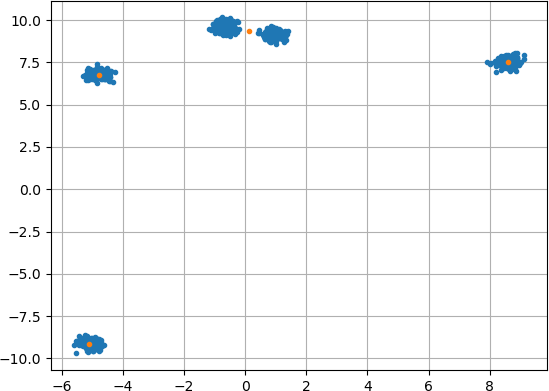

In [9]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
features, true_labels = make_blobs(n_samples=1_000, centers=5, cluster_std=0.2)
assert 3 <= (features | kmeans() | cli.shape(0)) <= 6
plt.plot(*features.T, "."); plt.plot(*features | kmeans() | cli.T(), "."); plt.grid(True); im = plt.gcf() | cli.toImg()
im | cli.toBytes() | cli.file("../../docs/images/kmeans.png"); im

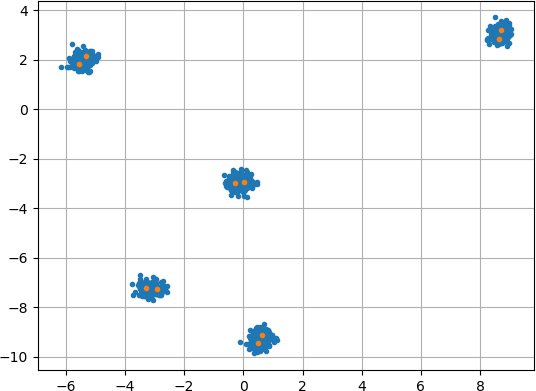

In [10]:
features, true_labels = make_blobs(n_samples=1_000, centers=5, cluster_std=0.2)
plt.plot(*features.T, "."); plt.plot(*features | kmeans(10) | cli.T(), "."); plt.grid(True); im = plt.gcf() | cli.toImg(); im

In [11]:
#export
skmani = k1lib.dep("sklearn.manifold")
class tsne(BaseCli):
    def __init__(self, n=2, **kwargs):
        """Transforms feature vectors of shape (N, F) down to (N, 2) for easy plotting.
Example::

    from sklearn.datasets import make_blobs
    features, true_labels = make_blobs(n_samples=1_000, n_features=5, centers=5, cluster_std=0.2)

    features | shape()          # returns (1000, 5)
    features | tsne() | shape() # returns (1000, 2)
    # plotting things out that has nice colors and whatnot
    features | tsne() & kmeans(5, 2) | ~aS(lambda xy,c: plt.scatter(*xy.T,c=c))

.. image:: ../images/tsne.png

:param n: number of output components (aka size of feature vector)
:param kwargs: other keyword arguments passed into ``sklearn.manifold.TSNE``"""
        self.n = n; self.kwargs = kwargs
    def __ror__(self, it):
        if not isinstance(it, k1lib.settings.cli.arrayTypes): it = np.array(list(it))
        return skmani.TSNE(self.n, **self.kwargs).fit_transform(it)

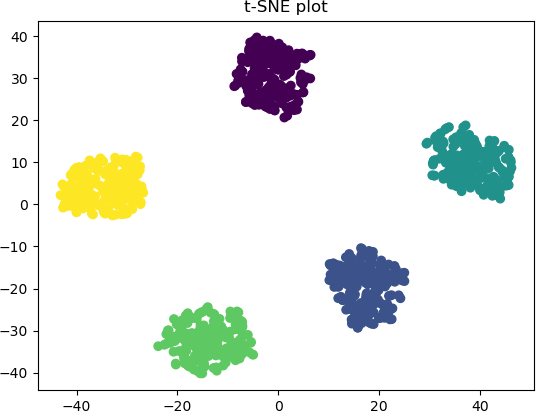

In [12]:
features, true_labels = make_blobs(n_samples=1_000, n_features=5, centers=5, cluster_std=0.2)
features | (tsne() | cli.transpose()) & kmeans(5, 2) | ~cli.aS(lambda xy,c: plt.scatter(*xy,c=c))
plt.title("t-SNE plot"); im = plt.gcf() | cli.toImg(); im | cli.toBytes() | cli.file("../../docs/images/tsne.png"); im

In [37]:
pybloom_live.ScalableBloomFilter

<module 'pybloom_live' from '/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/pybloom_live/__init__.py'>

In [49]:
#export
settings.add("bloom", k1lib.Settings().add("scalable", k1lib.Settings().add("capacity", 1000, "initial filter's capacity").add("growth", 4, "how fast does the filter's capacity grow over time when the capacity is reached"), "settings for when you don't declare the bloom's capacity ahead of time"), "bloom filter settings")
pybloom_live = k1lib.dep("pybloom_live", "pybloom-live", "https://github.com/joseph-fox/python-bloomfilter, https://pypi.org/project/pybloom-live/")
class bloom(BaseCli):
    def __init__(self, n:int=None, p:float=0.1, overflow:bool=False):
        """Creates a bloom filter.
Example::

    bf = ["raptor", "skylake", "merlin", "twinscan nxt", "sapphire rapids"] | bloom()
    "raptor"       in bf # returns True
    "twinscan nxt" in bf # returns True
    "twin"         in bf # most likely returns False, small chance returns True

This also allows distributed computing quite easily::

    bf = range(10) | applyMp(lambda i: cat(f"file-{i}.txt") | bloom()) | bloom.join()

This code assumes that you have 10 files filled with text with file names "file-1.txt" and
you want to check whether a string exists or not in all of those files. It is expected that

.. admonition:: Scalable bloom filter

    It's possible to leave the filter's capacity empty, which will create an initial filter
    with capacity 1000. When that capacity is reached, it will expand the filter to a capacity
    of 4000. Then 16000, and so on. This can be tweaked in the settings::
    
        settings.cli.models.bloom.scalable.capacity = 2000 # sets filter's default initial capacity
        settings.cli.models.bloom.scalable.growth = 2      # sets filter's growth factor when it runs out of space

    Because fundamentally, bloom filters can't grow, internally, this will create multiple bloom
    filters with increasing capacity, and whenever you search for a term, it will have to search
    through multiple filters to get the answer. So even though you can leave the capacity empty,
    it will degrade performance a little bit, which might be undesirable.

:param n: number of elements to be stored, aka filter's capacity
:param p: false positive probability (put 0.1 for 10% false positive, 0.01 for 1%)
:param overflow: if True, allows append more elements than the capacity of the filter, else (default) don't allow it"""
        self.n = n; self.p = p; self.overflow = overflow
    def __ror__(self, it):
        n = self.n; p = self.p
        bf = pybloom_live.ScalableBloomFilter(settings.bloom.scalable.capacity, p, settings.bloom.scalable.growth) if n is None else pybloom_live.BloomFilter(n, p)
        if self.overflow:
            for e in it:
                try: bf.add(e)
                except IndexError: bf.count = 0; bf.add(e)
        else:
            for e in it: bf.add(e)
        return bf
    @staticmethod
    def join():
        def inner(bfs):
            bfs = list(bfs)
            if len(set([type(b) for b in bfs])) > 1: raise Exception("Can't join normal filters and scalable filters together. Please specify a common capacity to all of the bloom filters")
            if type(bfs[0]) == pybloom_live.BloomFilter: # my implementation, which should be a little faster than builtin .union()
                b = bfs[0].copy()
                for b_ in bfs[1:]: b.bitarray |= b_.bitarray
                return b
            else: # has to use complex .union() in this case
                b = bfs[0]
                for b_ in bfs[1:]: b = b.union(b_)
                return b
        return cli.aS(inner)
try:
    import pybloom_live
    @k1lib.patch(pybloom_live.pybloom.BloomFilter)
    def __or__(self, other):
        if isinstance(other, BaseCli): return other.__ror__(self)
        return self.union(other)
except: pass

In [52]:
bf = ["raptor", "skylake", "merlin", "twinscan nxt", "sapphire rapids"] | bloom(10, 0.01)
assert "twin" not in bf; assert "twinscan nxt" in bf
bf = ["raptor", "skylake", "merlin", "twinscan nxt", "sapphire rapids"] | bloom(p=0.01)
assert "twin" not in bf; assert "twinscan nxt" in bf
bf = [["raptor", "skylake"], ["merlin", "twinscan nxt"], ["sapphire rapids"]] | cli.apply(bloom(10, 0.01)) | bloom.join()
assert "twin" not in bf; assert "twinscan nxt" in bf
bf = [["raptor", "skylake"], ["merlin", "twinscan nxt"], ["sapphire rapids"]] | cli.apply(bloom(p=0.01)) | bloom.join()
assert "twin" not in bf; assert "twinscan nxt" in bf

In [1]:
!../../export.py cli/models

2023-10-05 13:10:23,771	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 192.168.1.133:6379...
2023-10-05 13:10:23,777	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
7360    1   40%   
11097   0   60%   
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.4.3.8
Uninstalling k1lib-1.4.3.8:
  Successfully uninstalled k1lib-1.4.3.8
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-I